[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/python35/IINTS-SDK/blob/main/examples/notebooks/07_Ablation_Supervisor.ipynb)


In [1]:
import os
import sys
from pathlib import Path
import subprocess

def _ensure_repo():
    workspace = os.environ.get('GITHUB_WORKSPACE')
    if workspace:
        repo_root = Path(workspace).resolve()
        src_path = repo_root / 'src'
        if src_path.exists():
            sys.path.insert(0, str(src_path))
            return repo_root
    repo_root = Path().resolve()
    src_path = repo_root / 'src'
    if src_path.exists():
        sys.path.insert(0, str(src_path))
        return repo_root
    repo_dir = Path('IINTS-SDK')
    if not repo_dir.exists():
        subprocess.check_call(['git', 'clone', 'https://github.com/python35/IINTS-SDK.git'])
    repo_root = repo_dir.resolve()
    os.chdir(repo_root)
    src_path = repo_root / 'src'
    sys.path.insert(0, str(src_path))
    return repo_root

_ensure_repo()


PosixPath('/home/runner/work/IINTS-SDK/IINTS-SDK')

# Ablation: With vs. Without the Independent Supervisor

This notebook demonstrates the safety impact of the Supervisor layer
by running the same risky controller with and without safety guards.


In [2]:
import json
from pathlib import Path
from iints.presets import load_presets

import matplotlib.pyplot as plt
from iints.utils.plotting import apply_plot_style
import iints
import yaml
from importlib import resources
from iints.core.simulator import Simulator
from iints.core.patient.models import PatientModel
from iints.core.algorithms.pid_controller import PIDController
from iints.validation import build_stress_events, validate_patient_config_dict
from iints.core.supervisor import SafetyLevel

apply_plot_style()

presets = load_presets()
preset = next(p for p in presets if p["name"] == "pizza_paradox")

patient_config = yaml.safe_load(resources.read_text("iints.data.virtual_patients", f"{preset['patient_config']}.yaml"))
patient_params = validate_patient_config_dict(patient_config).model_dump()

class AggressiveAlgorithm(PIDController):
    """Always requests a high bolus to stress-test safety."""
    def predict_insulin(self, data):
        return {"total_insulin_delivered": 4.0}

class PassThroughSupervisor:
    def evaluate_safety(self, current_glucose, proposed_insulin, current_time, current_iob=0.0):
        return {
            "approved_insulin": proposed_insulin,
            "safety_level": SafetyLevel.SAFE,
            "actions_taken": [],
            "original_insulin": proposed_insulin,
            "insulin_reduction": 0.0,
            "emergency_mode": False,
            "safety_decision": None,
            "safety_reason": "APPROVED",
            "safety_triggered": False,
        }

    def get_safety_report(self):
        return {
            "total_violations": 0,
            "violation_breakdown": {"safe": 0, "warning": 0, "critical": 0, "emergency": 0},
            "bolus_interventions_count": 0,
            "emergency_mode_active": False,
            "current_iob": 0.0,
            "recent_violations": [],
        }

    def reset(self):
        pass

def run_sim(supervised: bool):
    patient = PatientModel(**patient_params)
    simulator = Simulator(
        patient_model=patient,
        algorithm=AggressiveAlgorithm(),
        time_step=preset["time_step_minutes"],
        seed=7,
    )
    if not supervised:
        simulator.supervisor = PassThroughSupervisor()

    for event in build_stress_events(preset["scenario"]["stress_events"]):
        simulator.add_stress_event(event)

    results, safety = simulator.run_batch(duration_minutes=360)
    return results, safety

results_unsup, safety_unsup = run_sim(supervised=False)
results_sup, safety_sup = run_sim(supervised=True)

safety_unsup, safety_sup


/tmp/ipykernel_2389/1982737527.py:21: DeprecationWarning: read_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  patient_config = yaml.safe_load(resources.read_text("iints.data.virtual_patients", f"{preset['patient_config']}.yaml"))
Simulation terminated early: Critical failure: glucose < 40.0 mg/dL for 30 minutes.


Simulation terminated early: Critical failure: glucose < 40.0 mg/dL for 30 minutes.


({'total_violations': 0,
  'violation_breakdown': {'safe': 0,
   'warning': 0,
   'critical': 0,
   'emergency': 0},
  'bolus_interventions_count': 0,
  'emergency_mode_active': False,
  'current_iob': 0.0,
  'recent_violations': [],
  'terminated_early': True,
  'termination_reason': {'reason': 'Critical failure: glucose < 40.0 mg/dL for 30 minutes.',
   'current_time_minutes': 55,
   'glucose_value': 20,
   'duration_minutes': 30}},
 {'total_violations': 13,
  'violation_breakdown': {'safe': 3,
   'warning': 1,
   'critical': 2,
   'emergency': 7},
  'bolus_interventions_count': 13,
  'emergency_mode_active': True,
  'current_iob': 2.4000000000000004,
  'recent_violations': [{'level': 'emergency',
    'message': 'HYPO_CUTOFF: Glucose below safety cutoff; EMERGENCY_STOP: Severe hypoglycemia detected',
    'glucose': 28.1696735279297,
    'time': 40.0,
    'original_proposed_insulin': 4.0,
    'approved_insulin': 0},
   {'level': 'emergency',
    'message': 'HYPO_CUTOFF: Glucose below 

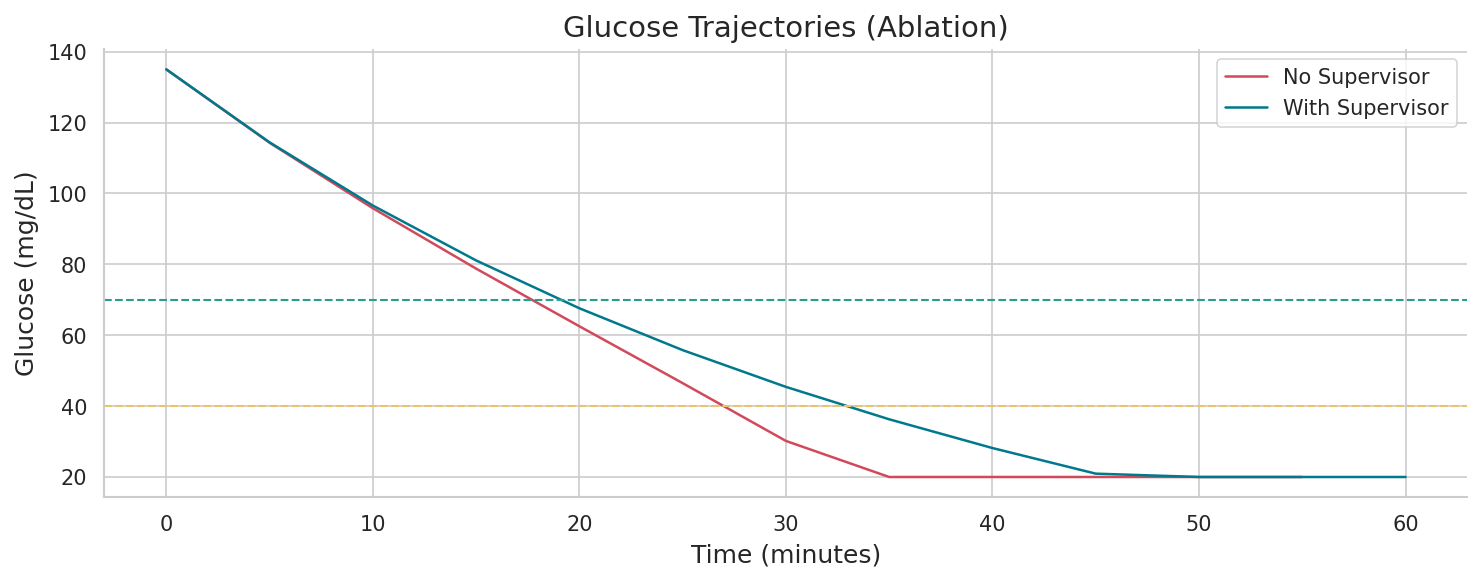

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(results_unsup["time_minutes"], results_unsup["glucose_actual_mgdl"], label="No Supervisor", color="#d1495b")
plt.plot(results_sup["time_minutes"], results_sup["glucose_actual_mgdl"], label="With Supervisor", color="#00798c")
plt.axhline(70, color="#2a9d8f", linestyle="--", linewidth=1)
plt.axhline(40, color="#e9c46a", linestyle="--", linewidth=1)
plt.title("Glucose Trajectories (Ablation)")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
{
    "no_supervisor": safety_unsup.get("termination_reason", "ok"),
    "with_supervisor": safety_sup.get("termination_reason", "ok"),
}


{'no_supervisor': {'reason': 'Critical failure: glucose < 40.0 mg/dL for 30 minutes.',
  'current_time_minutes': 55,
  'glucose_value': 20,
  'duration_minutes': 30},
 'with_supervisor': {'reason': 'Critical failure: glucose < 40.0 mg/dL for 30 minutes.',
  'current_time_minutes': 60,
  'glucose_value': 20,
  'duration_minutes': 30}}